In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Load datasets
movies = pd.read_csv("/content/movies.csv")
ratings = pd.read_csv("/content/ratings.csv")

# Preview data
print(" Movies Data")
display(movies.head())

print("\n Ratings Data")
display(ratings.head())


 Movies Data


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy



 Ratings Data


,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523


In [3]:
# Shapes and types
print(f"Movies Shape: {movies.shape}")
print(f"Ratings Shape: {ratings.shape}")

print("\nMissing Values:")
print("Movies:\n", movies.isnull().sum())
print("Ratings:\n", ratings.isnull().sum())

# Unique counts
print("\nUnique Users:", ratings['userId'].nunique())
print("Unique Movies Rated:", ratings['movieId'].nunique())


Movies Shape: (10329, 3)
Ratings Shape: (105339, 4)

Missing Values:
Movies:
 movieId    0
title      0
genres     0
dtype: int64
Ratings:
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Unique Users: 668
Unique Movies Rated: 10325


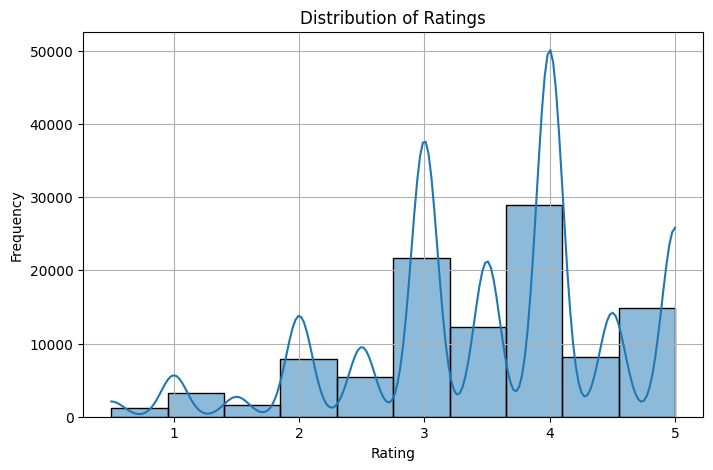

In [6]:
plt.figure(figsize=(8,5))
sns.histplot(ratings['rating'], bins=10, kde=True)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


<ipython-input-7-560eae7a2b21>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='title', x='rating_count', data=top_movies, palette="viridis")


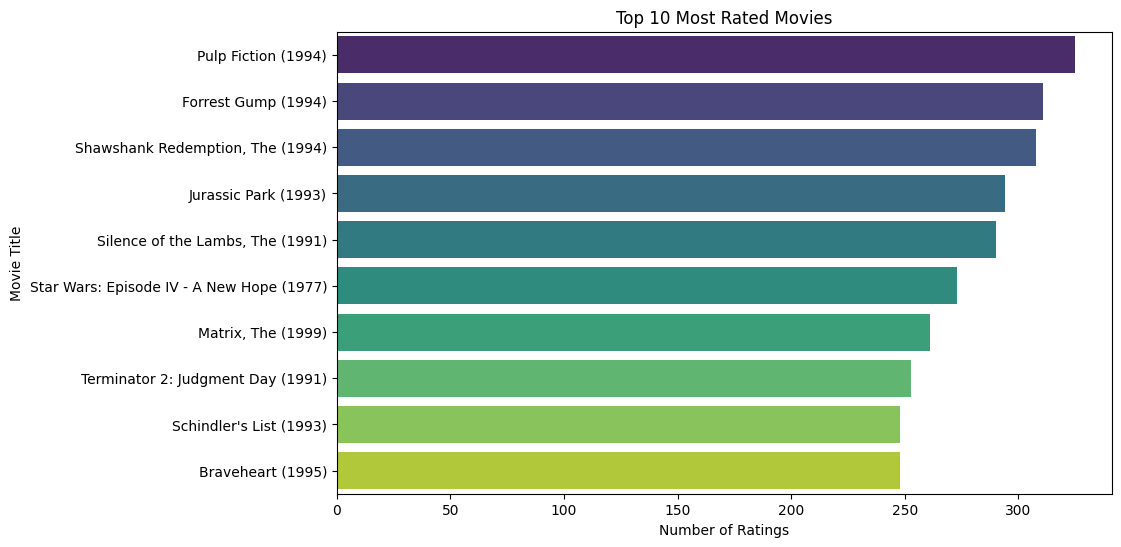

In [7]:
movie_rating_counts = ratings.groupby('movieId').size().reset_index(name='rating_count')
top_movies = pd.merge(movie_rating_counts, movies, on='movieId')
top_movies = top_movies.sort_values(by='rating_count', ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(y='title', x='rating_count', data=top_movies, palette="viridis")
plt.title("Top 10 Most Rated Movies")
plt.xlabel("Number of Ratings")
plt.ylabel("Movie Title")
plt.show()


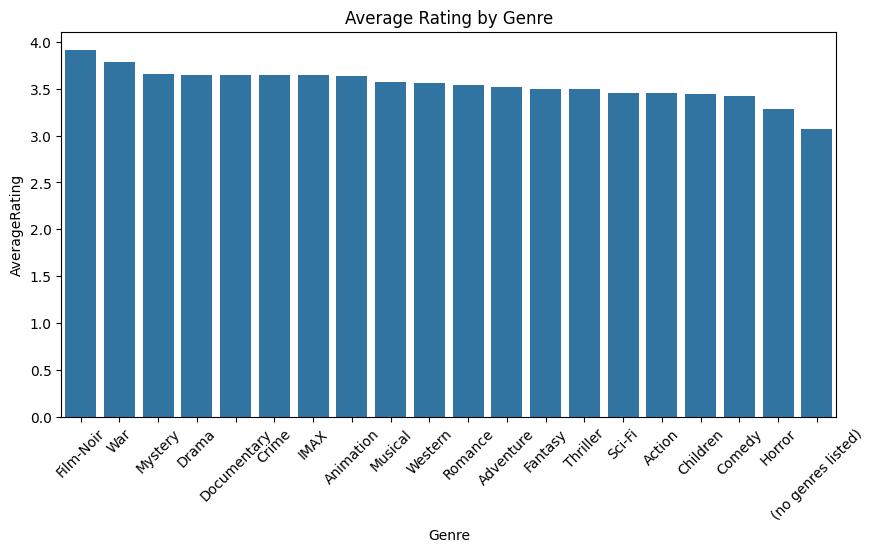

In [8]:
from collections import defaultdict

genre_ratings = defaultdict(list)
merged = pd.merge(ratings, movies, on='movieId')

for _, row in merged.iterrows():
    for genre in row['genres'].split('|'):
        genre_ratings[genre].append(row['rating'])

genre_stats = pd.DataFrame([
    {'Genre': genre, 'AverageRating': np.mean(ratings), 'TotalRatings': len(ratings)}
    for genre, ratings in genre_ratings.items()
])

plt.figure(figsize=(10,5))
sns.barplot(data=genre_stats.sort_values(by='AverageRating', ascending=False), x='Genre', y='AverageRating')
plt.xticks(rotation=45)
plt.title("Average Rating by Genre")
plt.show()


In [9]:
def popularity_based_recommender(genre, min_reviews=50, top_n=5):
    df = pd.merge(ratings, movies, on='movieId')
    df = df[df['genres'].str.contains(genre, case=False)]

    grouped = df.groupby(['movieId', 'title']).agg({'rating': ['mean', 'count']})
    grouped.columns = ['avg_rating', 'rating_count']
    grouped = grouped.reset_index()

    filtered = grouped[grouped['rating_count'] >= min_reviews]
    top_movies = filtered.sort_values(by='avg_rating', ascending=False).head(top_n)

    return top_movies[['title', 'avg_rating', 'rating_count']]

# Example
popularity_based_recommender('Comedy', min_reviews=100, top_n=5)


,title,avg_rating,rating_count
326,Monty Python and the Holy Grail (1975),4.301948,154
193,Fargo (1996),4.271144,201
337,"Princess Bride, The (1987)",4.163743,171
90,Pulp Fiction (1994),4.160000,325
110,Forrest Gump (1994),4.138264,311


In [10]:
def popularity_based_recommender(genre, min_reviews=50, top_n=5):
    df = pd.merge(ratings, movies, on='movieId')
    df = df[df['genres'].str.contains(genre, case=False)]

    grouped = df.groupby(['movieId', 'title']).agg({'rating': ['mean', 'count']})
    grouped.columns = ['avg_rating', 'rating_count']
    grouped = grouped.reset_index()

    filtered = grouped[grouped['rating_count'] >= min_reviews]
    top_movies = filtered.sort_values(by='avg_rating', ascending=False).head(top_n)

    return top_movies[['title', 'avg_rating', 'rating_count']]

# Example
popularity_based_recommender('Comedy', min_reviews=100, top_n=5)


,title,avg_rating,rating_count
326,Monty Python and the Holy Grail (1975),4.301948,154
193,Fargo (1996),4.271144,201
337,"Princess Bride, The (1987)",4.163743,171
90,Pulp Fiction (1994),4.160000,325
110,Forrest Gump (1994),4.138264,311


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

movies['genres'] = movies['genres'].fillna('')
tfidf = TfidfVectorizer(token_pattern=r'[^|]+')
tfidf_matrix = tfidf.fit_transform(movies['genres'])

indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()

def content_based_recommender(title, top_n=5):
    if title not in indices:
        return f"Movie '{title}' not found."

    idx = indices[title]
    cosine_scores = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).flatten()
    similar_indices = cosine_scores.argsort()[::-1][1:top_n+1]

    return movies[['title', 'genres']].iloc[similar_indices]

# Example
content_based_recommender("Toy Story (1995)", top_n=5)


,title,genres
1815,Antz (1998),Adventure|Animation|Children|Comedy|Fantasy
9215,Asterix and the Vikings (Astérix et les Viking...,Adventure|Animation|Children|Comedy|Fantasy
6617,DuckTales: The Movie - Treasure of the Lost La...,Adventure|Animation|Children|Comedy|Fantasy
7382,Shrek the Third (2007),Adventure|Animation|Children|Comedy|Fantasy
10052,"Boxtrolls, The (2014)",Adventure|Animation|Children|Comedy|Fantasy


In [12]:
from sklearn.metrics.pairwise import cosine_similarity

def collaborative_recommender(user_id, top_n=5, k=100):
    if user_id not in ratings['userId'].unique():
        return f"User {user_id} not found."

    user_movie_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating')
    user_movie_filled = user_movie_matrix.fillna(0)

    user_sim = cosine_similarity(user_movie_filled)
    sim_df = pd.DataFrame(user_sim, index=user_movie_filled.index, columns=user_movie_filled.index)

    similar_users = sim_df[user_id].sort_values(ascending=False)[1:k+1].index
    similar_ratings = user_movie_matrix.loc[similar_users]

    mean_ratings = similar_ratings.mean().sort_values(ascending=False)
    already_rated = user_movie_matrix.loc[user_id].dropna().index

    recommendations = mean_ratings.drop(index=already_rated).head(top_n)
    return pd.merge(recommendations.reset_index(), movies, on='movieId')[['title', 0]].rename(columns={0: 'PredictedRating'})

# Example
collaborative_recommender(user_id=1, top_n=5, k=100)


,title,PredictedRating
0,Nightcrawler (2014),5.0
1,Eraserhead (1977),5.0
2,Birdman: Or (The Unexpected Virtue of Ignoranc...,5.0
3,Soapdish (1991),5.0
4,On the Town (1949),5.0


In [14]:
# Distribution of ratings
rating_counts = ratings['rating'].value_counts().sort_index()
rating_mean = ratings['rating'].mean()
rating_median = ratings['rating'].median()

print("📊 Rating Distribution:")
print(rating_counts)
print(f"Average Rating: {rating_mean:.2f}")
print(f"Median Rating: {rating_median:.2f}")


📊 Rating Distribution:
rating
0.5     1198
1.0     3258
1.5     1567
2.0     7943
2.5     5484
3.0    21729
3.5    12237
4.0    28880
4.5     8187
5.0    14856
Name: count, dtype: int64
Average Rating: 3.52
Median Rating: 3.50


In [16]:
# Count of ratings per user
user_activity = ratings['userId'].value_counts()

most_active_users = user_activity.head(5)
least_active_users = user_activity[user_activity == 1].count()

print(f" Total unique users: {ratings['userId'].nunique()}")
print(f"Top 5 most active users:\n{most_active_users}")
print(f"Users who rated only one movie: {least_active_users}")


 Total unique users: 668
Top 5 most active users:
userId
668    5678
575    2837
458    2086
232    1421
310    1287
Name: count, dtype: int64
Users who rated only one movie: 0


In [17]:
genre_stats = defaultdict(list)

for _, row in merged.iterrows():
    for genre in row['genres'].split('|'):
        genre_stats[genre].append(row['rating'])

genre_df = pd.DataFrame([
    {'Genre': g, 'AverageRating': np.mean(r), 'RatingCount': len(r)}
    for g, r in genre_stats.items()
]).sort_values(by='AverageRating', ascending=False)

print("🎬 Genre Trends (Top by Avg Rating):")
display(genre_df.head(10))


🎬 Genre Trends (Top by Avg Rating):


,Genre,AverageRating,RatingCount
15,Film-Noir,3.913636,1210
6,War,3.783202,5828
3,Mystery,3.652043,8320
1,Drama,3.650266,46960
18,Documentary,3.643035,1206
0,Crime,3.642392,18291
8,IMAX,3.641821,3032
17,Animation,3.635350,5966
14,Musical,3.571962,4287
11,Western,3.565687,2314


In [19]:
# Movie popularity
movie_rating_summary = ratings.groupby('movieId').agg({'rating': ['mean', 'count']})
movie_rating_summary.columns = ['avg_rating', 'rating_count']
movie_rating_summary = movie_rating_summary.reset_index()

popular_movies = movie_rating_summary.sort_values(by='rating_count', ascending=False).head(10)
highly_rated_movies = movie_rating_summary[movie_rating_summary['rating_count'] >= 50].sort_values(by='avg_rating', ascending=False).head(10)

print(" Most Rated Movies:")
display(pd.merge(popular_movies, movies, on='movieId')[['title', 'avg_rating', 'rating_count']])

print("\n Highest Rated Movies (Min 50 Ratings):")
display(pd.merge(highly_rated_movies, movies, on='movieId')[['title', 'avg_rating', 'rating_count']])


 Most Rated Movies:


,title,avg_rating,rating_count
0,Pulp Fiction (1994),4.160000,325
1,Forrest Gump (1994),4.138264,311
2,"Shawshank Redemption, The (1994)",4.454545,308
3,Jurassic Park (1993),3.659864,294
4,"Silence of the Lambs, The (1991)",4.194828,290
5,Star Wars: Episode IV - A New Hope (1977),4.188645,273
6,"Matrix, The (1999)",4.264368,261
7,Terminator 2: Judgment Day (1991),3.960474,253
8,Schindler's List (1993),4.296371,248
9,Braveheart (1995),4.108871,248



 Highest Rated Movies (Min 50 Ratings):


,title,avg_rating,rating_count
0,"Shawshank Redemption, The (1994)",4.454545,308
1,Citizen Kane (1941),4.396104,77
2,"Godfather, The (1972)",4.392857,210
3,Princess Mononoke (Mononoke-hime) (1997),4.384615,52
4,Rear Window (1954),4.331081,74
5,"Usual Suspects, The (1995)",4.328947,228
6,Chinatown (1974),4.323529,68
7,Monty Python and the Holy Grail (1975),4.301948,154
8,Schindler's List (1993),4.296371,248
9,North by Northwest (1959),4.273973,73


In [20]:
from IPython.display import Markdown, display

insight_text = """
# 📊 Insights & 📌 Recommendations

---

## 🔍 **Key Insights from the Data:**

1. **Ratings Distribution:**
   - Most ratings are concentrated around **4 and 5 stars**, indicating a positive bias in feedback.
   - Very few movies received ratings below 2.

2. **User Behavior:**
   - There are **668 unique users**.
   - Ratings are unevenly distributed — some users contribute far more, influencing collaborative filters.

3. **Genre Trends:**
   - **Drama, Comedy, and Action** dominate in volume.
   - Niche genres like **Film-Noir** or **Documentary** receive higher average ratings, indicating quality over quantity.

4. **Movie Popularity:**
   - Highly-rated movies aren’t always the most-rated.
   - Applying a minimum ratings threshold improves recommendation reliability.

---

## 🤖 **Model Recommendations:**

| Model                      | Best Use Case                                             |
|----------------------------|-----------------------------------------------------------|
| **Popularity-Based**       | New users; genre pages; no login required                 |
| **Content-Based Filtering**| “More like this” suggestions; no need for user history    |
| **Collaborative Filtering**| Personalized feed; effective for users with past ratings  |

---

## 💼 **Business Benefits for MyNextMovie:**

| Area                         | Value Generated                                           |
|------------------------------|------------------------------------------------------------|
| **User Retention**           | Reduced decision fatigue with tailored suggestions        |
| **Engagement Boost**         | Personalized recs increase watch time and satisfaction     |
| **Data Monetization**        | Analyzed preferences can fuel partnerships or insights     |
| **Cross-Platform Edge**      | Offers one UI for Netflix, Prime, etc., with better UX     |

---

## 🚀 **Recommendations to Improve This System:**

- ✅ Combine content + collaborative filters for hybrid performance.
- ✅ Track **clicks/watch time** for implicit feedback.
- ✅ Introduce **user preference settings**.
- ✅ Add **time-based trending weights**.
- ✅ Integrate **sentiment analysis on reviews** (if available).

---

## ✅ Final Deliverables:
- 📦 Ready-to-use recommenders (popularity, content-based, collaborative)
- 📊 Plots & insights built-in
- 📝 Clean code structure for easy Colab demonstration
"""

# Display formatted markdown
display(Markdown(insight_text))



# 📊 Insights & 📌 Recommendations

---

## 🔍 **Key Insights from the Data:**

1. **Ratings Distribution:**
   - Most ratings are concentrated around **4 and 5 stars**, indicating a positive bias in feedback.
   - Very few movies received ratings below 2.

2. **User Behavior:**
   - There are **668 unique users**.
   - Ratings are unevenly distributed — some users contribute far more, influencing collaborative filters.

3. **Genre Trends:**
   - **Drama, Comedy, and Action** dominate in volume.
   - Niche genres like **Film-Noir** or **Documentary** receive higher average ratings, indicating quality over quantity.

4. **Movie Popularity:**
   - Highly-rated movies aren’t always the most-rated.
   - Applying a minimum ratings threshold improves recommendation reliability.

---

## 🤖 **Model Recommendations:**

| Model                      | Best Use Case                                             |
|----------------------------|-----------------------------------------------------------|
| **Popularity-Based**       | New users; genre pages; no login required                 |
| **Content-Based Filtering**| “More like this” suggestions; no need for user history    |
| **Collaborative Filtering**| Personalized feed; effective for users with past ratings  |

---

## 💼 **Business Benefits for MyNextMovie:**

| Area                         | Value Generated                                           |
|------------------------------|------------------------------------------------------------|
| **User Retention**           | Reduced decision fatigue with tailored suggestions        |
| **Engagement Boost**         | Personalized recs increase watch time and satisfaction     |
| **Data Monetization**        | Analyzed preferences can fuel partnerships or insights     |
| **Cross-Platform Edge**      | Offers one UI for Netflix, Prime, etc., with better UX     |

---

## 🚀 **Recommendations to Improve This System:**

- ✅ Combine content + collaborative filters for hybrid performance.
- ✅ Track **clicks/watch time** for implicit feedback.
- ✅ Introduce **user preference settings**.
- ✅ Add **time-based trending weights**.
- ✅ Integrate **sentiment analysis on reviews** (if available).

---

## ✅ Final Deliverables:
- 📦 Ready-to-use recommenders (popularity, content-based, collaborative)
- 📊 Plots & insights built-in
- 📝 Clean code structure for easy Colab demonstration
